In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [3]:
prior_mu = torch.zeros(2)
prior_cov = torch.eye(2)
theta = torch.distributions.MultivariateNormal(prior_mu, prior_cov)
theta

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

In [4]:
theta.loc, theta.covariance_matrix

(tensor([0., 0.]),
 tensor([[1., 0.],
         [0., 1.]]))

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


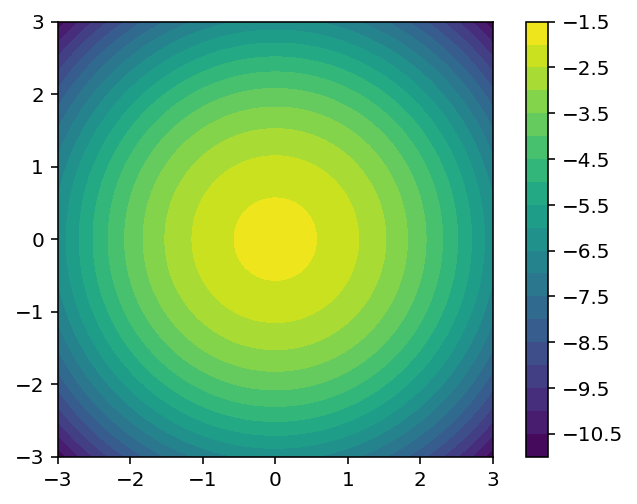

In [5]:
# Plot the prior in 2d contour

theta1 = torch.linspace(-3, 3, 100)
theta2 = torch.linspace(-3, 3, 100)

theta1, theta2 = torch.meshgrid(theta1, theta2)

theta_values = torch.stack((theta1, theta2), dim=-1)  # Shape: (100, 100, 2)

z = theta.log_prob(theta_values.view(-1, 2))  # Shape: (10000,)
z = z.view(100, 100)  # Reshape to (100, 100)

plt.contourf(theta1.numpy(), theta2.numpy(), z.numpy(), 20)
plt.gca().set_aspect('equal')

plt.colorbar()


In [6]:
theta_sample = theta.sample((1000,))
theta_sample

tensor([[-2.0856, -0.1921],
        [ 2.3394, -0.4502],
        [ 1.0702, -0.4221],
        ...,
        [ 1.1139, -0.6868],
        [-0.6670, -2.2186],
        [-0.3922, -1.7325]])

In [7]:
x_lin = torch.linspace(-1, 1, 100)
y_lin = theta_sample[:, 0].unsqueeze(1) + theta_sample[:, 1].unsqueeze(1) * x_lin.unsqueeze(0)

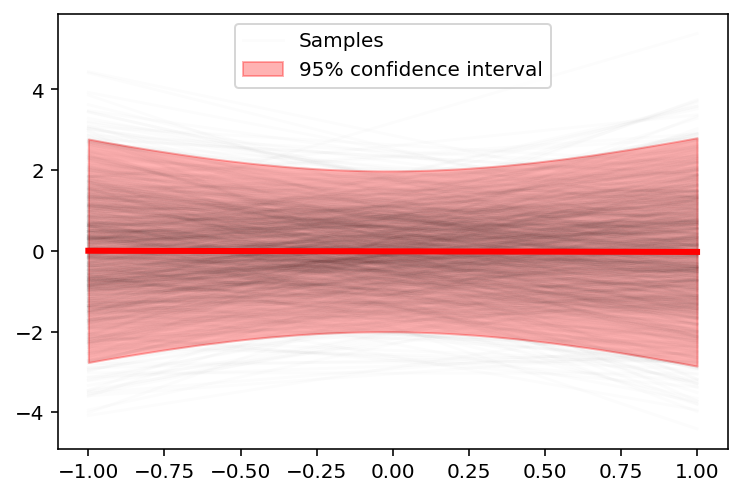

In [8]:
_ = plt.plot(x_lin.numpy(), y_lin.numpy().T, alpha=0.01, color='black')

# Plot the last sample to see the line and mark the label
_ = plt.plot(x_lin.numpy(), y_lin.numpy()[-1], alpha=0.01, color='black', label='Samples')

# Mean prediction
y_pred_mean = y_lin.mean(dim=0)
plt.plot(x_lin.numpy(), y_pred_mean.numpy(), color='red', linewidth=3)

# 95% confidence interval
y_pred_std = y_lin.std(dim=0)
plt.fill_between(x_lin.numpy(), (y_pred_mean - 2 * y_pred_std).numpy(), (y_pred_mean + 2 * y_pred_std).numpy(), alpha=0.3, color='red', label='95% confidence interval')

plt.legend()


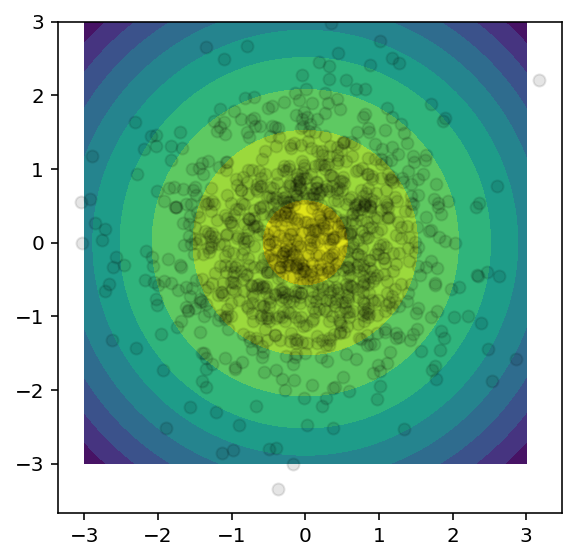

In [9]:
# Plot the theta samples on the contour plot as scatter points

plt.contourf(theta1.numpy(), theta2.numpy(), z.numpy(), 10)
plt.gca().set_aspect('equal')


plt.scatter(theta_sample[:, 0].numpy(), theta_sample[:, 1].numpy(), alpha=0.1, color='black')
plt.tight_layout()

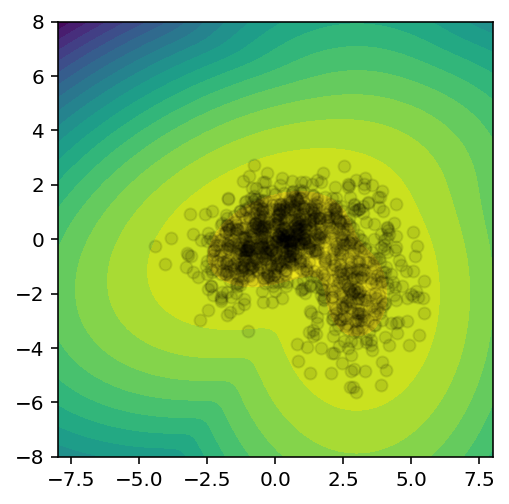

In [17]:
# Use a different prior distribution: a mixture of two Gaussians

pis = torch.tensor([0.7, 0.3])
norm1 = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[2.0, 0.5], [0.5, 1.0]]))
norm2 = torch.distributions.MultivariateNormal(torch.tensor([3.0, -2.0]), torch.tensor([[1.0, 0.0], [0.0, 2.0]]))

mog = torch.distributions.MixtureSameFamily(torch.distributions.Categorical(pis), 
                                            torch.distributions.MultivariateNormal(torch.stack((norm1.loc, norm2.loc)),
                                             torch.stack((norm1.covariance_matrix, norm2.covariance_matrix))))

theta = mog.sample((1000,))

# Plot the samples


# Plot the prior in 2d contour

theta1 = torch.linspace(-8, 8, 100)
theta2 = torch.linspace(-8, 8, 100)

theta1, theta2 = torch.meshgrid(theta1, theta2)

theta_values = torch.stack((theta1, theta2), dim=-1)  # Shape: (100, 100, 2)

z = mog.log_prob(theta_values.view(-1, 2))  # Shape: (10000,)
z = z.view(100, 100)  # Reshape to (100, 100)

plt.contourf(theta1.numpy(), theta2.numpy(), z.numpy(), 20)
plt.gca().set_aspect('equal')

plt.scatter(theta[:, 0].numpy(), theta[:, 1].numpy(), alpha=0.1, color='black')



In [18]:
theta_sample = mog.sample((1000,))
y_lin = theta_sample[:, 0].unsqueeze(1) + theta_sample[:, 1].unsqueeze(1) * x_lin.unsqueeze(0)

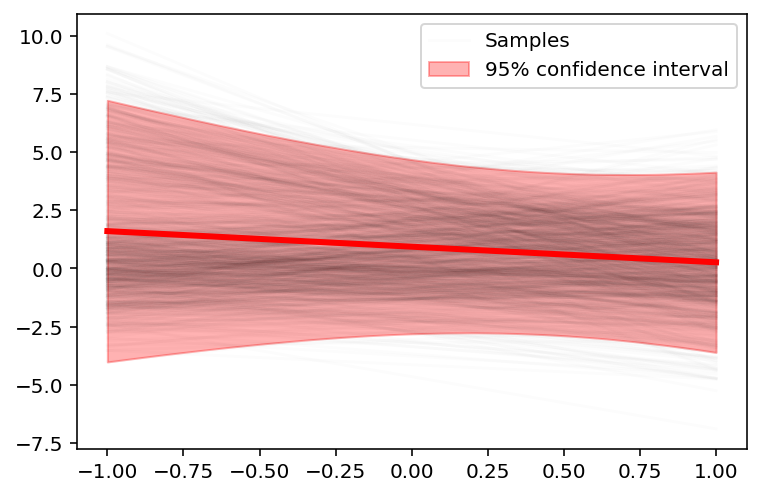

In [19]:
_ = plt.plot(x_lin.numpy(), y_lin.numpy().T, alpha=0.01, color='black')

# Plot the last sample to see the line and mark the label
_ = plt.plot(x_lin.numpy(), y_lin.numpy()[-1], alpha=0.01, color='black', label='Samples')

# Mean prediction
y_pred_mean = y_lin.mean(dim=0)
plt.plot(x_lin.numpy(), y_pred_mean.numpy(), color='red', linewidth=3)

# 95% confidence interval
y_pred_std = y_lin.std(dim=0)
plt.fill_between(x_lin.numpy(), (y_pred_mean - 2 * y_pred_std).numpy(), (y_pred_mean + 2 * y_pred_std).numpy(), alpha=0.3, color='red', label='95% confidence interval')

plt.legend()

# Closed form solution for prior predictive distribution

![CleanShot 2023-06-05 at 17.47.27@2x.png](<attachment:CleanShot 2023-06-05 at 17.47.27@2x.png>)
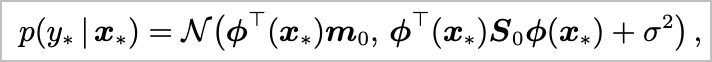

In [ ]:
sigma = 1.0

def prior_predictive(x, sigma, prior_mean, prior_cov):
    """Closed form prior predictive distribution for linear regression."""
    prior_pred_mean = prior_mean[0] + prior_mean[1] * x
    prior_pred_cov = sigma ** 2 + x ** 2 * prior_cov[1, 1]
    return prior_pred_mean, prior_pred_cov